# InceptionV3

InceptionV3 is a convolutional neural network designed to allow deeper networks while keeping the number of parameters small.

This notebook will train the InceptionV3 model.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import random
from random import shuffle 
import collections
import io
import math

import tensorflow as tf
from tensorflow import keras 

import warnings
warnings.filterwarnings("ignore")

In [11]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Input, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [6]:
# FLOWERS_DIR ='dataset/FlowerData-30'

path = '/content/drive/Shareddrives/Visual Information Processing/'
FLOWERS_DIR = path + 'FlowerData-30'

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
H, W = 224, 224
BATCH_SIZE = 64
EPOCHS = 100

TRAIN_FRACTION = 80
RANDOM_SEED = 2018

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    FLOWERS_DIR,
    target_size=(H, W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    FLOWERS_DIR,
    target_size=(H, W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=RANDOM_SEED
)

Found 1982 images belonging to 30 classes.
Found 491 images belonging to 30 classes.


## Building the Model 

We implemented transfer learning by loading a pretrained InceptionV3 (weights learned from the public ImageNet database). Several dense layer was added to the end of the model to make it classify our 30 flower classes.

In [13]:
inputs = tf.keras.Input(shape=(H, W, 3))

# base model
x = tf.keras.applications.InceptionV3(
    input_shape = (H, W, 3),
    weights = "imagenet",
    include_top = False
)

for layer in x.layers:
    layer.trainable = False
    
flat1 = GlobalAveragePooling2D()(x.layers[-1].output)
flat2 = Dropout(0.2)(flat1)
class1 = Dense(1024, activation='relu')(flat2)
output = Dense(30, activation='softmax')(class1)
model = Model(inputs=x.inputs, outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 111, 111, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 111, 111, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                           

In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [15]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(path+'InceptionV3_checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [16]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = train_generator.n / BATCH_SIZE, 
    validation_data = validation_generator,
    validation_steps = validation_generator.n / BATCH_SIZE,
    epochs = 100,
    callbacks=callbacks
)

Epoch 1/100
31/30 [==============================] - ETA: -1s - loss: 2.1134 - accuracy: 0.4374
Epoch 00001: val_loss improved from inf to 1.11084, saving model to /content/drive/Shareddrives/Visual Information Processing/InceptionV3_checkpoint.h5
30/30 [==============================] - 1669s 53s/step - loss: 2.1134 - accuracy: 0.4374 - val_loss: 1.1108 - val_accuracy: 0.6660 - lr: 0.0010
Epoch 2/100
31/30 [==============================] - ETA: 0s - loss: 0.8596 - accuracy: 0.7386
Epoch 00002: val_loss improved from 1.11084 to 0.63565, saving model to /content/drive/Shareddrives/Visual Information Processing/InceptionV3_checkpoint.h5
30/30 [==============================] - 42s 1s/step - loss: 0.8596 - accuracy: 0.7386 - val_loss: 0.6356 - val_accuracy: 0.7984 - lr: 0.0010
Epoch 3/100
31/30 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.8037
Epoch 00003: val_loss improved from 0.63565 to 0.62284, saving model to /content/drive/Shareddrives/Visual Information 

## Evaluation

In [17]:
def plot_accuracy_loss(history):
    
    ### Plot the accuracy and the loss during the training of the nn.
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', 
             label = "Training Accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', 
             label = "Validation Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', 
             label = "Training Loss")
    plt.plot(history.history['val_loss'], 'ro--', 
             label = "Validation Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

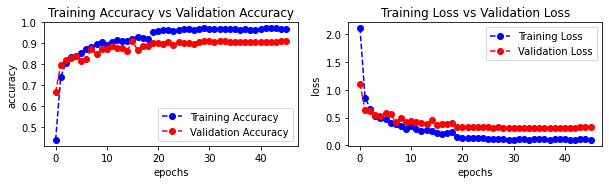

In [18]:
plot_accuracy_loss(history)

## Saving the Model

In [19]:
model.save(path+'InceptionV3.h5')